In [1]:
import random
import copy
import numpy as np
import pyspiel
from open_spiel.python.algorithms import mcts, random_agent, minimax
from othello_game import OthelloGame, OthelloState
from MCTS import MCTS
from Arena import Arena
from Coach import Coach
from BasicModel import BasicModel
from NNet import NNetWrapper
from QNet import QNetWrapper
from HybridQNet import HybridQNetWrapper
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as p_np
import torch

In [2]:
def plot_performance_history(history, name):
    x = [i for i, _ in history]
    random_wins = [results["random"][0] for _, results in history]
    random_draws = [results["random"][2] for _, results in history]
    random_losses = [results["random"][1] for _, results in history]
    mcts_wins = [results["mcts"][0] for _, results in history]
    mcts_draws = [results["mcts"][2] for _, results in history]
    mcts_losses = [results["mcts"][1] for _, results in history]

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    axs[0].bar(x, random_wins, color='g', width=2, label='random wins')
    axs[0].bar(x, random_draws, color='b', width=2, bottom=random_wins, label='random draws')
    axs[0].bar(x, random_losses, color='r', width=2, bottom=np.array(random_wins)+np.array(random_draws), label='random losses')

    axs[0].set_xticks(x)

    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Number of games')
    axs[0].set_title(f"{name} vs Random Agent")

    axs[1].bar(x, mcts_wins, color='g', width=2, label='mcts wins')
    axs[1].bar(x, mcts_draws, color='b', width=2, bottom=mcts_wins, label='mcts draws')
    axs[1].bar(x, mcts_losses, color='r', width=2, bottom=np.array(mcts_wins)+np.array(mcts_draws), label='mcts losses')

    axs[1].set_xticks(x)

    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Number of games')
    axs[1].set_title(f"{name} vs MCTS Agent")

In [3]:
game = pyspiel.load_game("othello_nxn", {"n": 6})
hybrid_qnet = HybridQNetWrapper(game, lr=0.0025, use_gpu=False)
print(f"hybrid_qnet params: {hybrid_qnet.total_params}")

Using CPU with lightning.qubit
hybrid_qnet params: 799


In [7]:
drawer = qml.draw(hybrid_qnet.qlayer, expansion_strategy="device", max_length=1000)
print(drawer(torch.ones((1, 3, 6)), hybrid_qnet.qlayer.weights))

0: ──RX(M0)──RY(M0)──RZ(M0)──Rot(3.86,0.32,3.43)─╭●─────────────╭X──Rot(2.04,5.11,5.86)─╭●──────────╭X──Rot(3.69,5.48,4.39)──────────────────────╭●───────╭X──Rot(1.05,2.57,2.88)───────────────────────────────────────────╭●────╭X──Rot(2.73,2.58,1.39)────────────────────────────────────────────────────────────────╭●─╭X──Rot(5.94,5.09,5.76)──────────────────────╭●───────────────────────────────────────────────────────────────────╭X─┤  <Z>
1: ──RX(M0)──RY(M0)──RZ(M0)──Rot(5.90,1.52,4.11)─╰X─╭●──────────│───Rot(0.50,0.77,5.66)─│──╭●───────│──╭X────────────────────Rot(5.90,2.06,4.90)─│──╭●────│──╭X────────────────────Rot(2.40,4.01,3.56)──────────────────────│──╭●─│──╭X────────────────────Rot(4.59,0.43,4.02)───────────────────────────────────────────│──╰●─╭X────────────────────Rot(5.01,3.03,0.73)─╰X───────────────────╭●──────────────────────────────────────────────│──┤  <Z>
2: ──RX(M0)──RY(M0)──RZ(M0)──Rot(4.67,5.13,0.82)────╰X─╭●───────│───Rot(4.04,0.16,4.93)─╰X─│──╭●────│──│────────────────

In [4]:
hybrid_qnet_coach = Coach(game, hybrid_qnet, numMCTSSims=25, max_history_len=8192, compare_games=50)
hybrid_qnet_coach.learn()

Iter 0
Testing...


Arena.playGames (2): 100%|██████████| 25/25 [02:25<00:00,  5.80s/it]


{'random': (26, 23, 1), 'mcts': (5, 43, 2)}
Iter 1


Self Play: 100%|██████████| 5/5 [00:43<00:00,  8.61s/it]


Epoch 0


Training Net: 100%|██████████| 3/3 [00:00<00:00, 23.82it/s, Loss_v=1.32e+00]


Epoch 1


Training Net: 100%|██████████| 3/3 [00:00<00:00, 27.08it/s, Loss_v=1.24e+00]


Epoch 2


Training Net: 100%|██████████| 3/3 [00:00<00:00, 27.48it/s, Loss_v=1.20e+00]


Epoch 3


Training Net: 100%|██████████| 3/3 [00:00<00:00, 22.09it/s, Loss_v=1.13e+00]


Epoch 4


Training Net: 100%|██████████| 3/3 [00:00<00:00, 26.35it/s, Loss_v=1.08e+00]


Epoch 5


Training Net: 100%|██████████| 3/3 [00:00<00:00, 24.53it/s, Loss_v=1.03e+00]


Epoch 6


Training Net: 100%|██████████| 3/3 [00:00<00:00, 23.89it/s, Loss_v=9.93e-01]


Epoch 7


Training Net: 100%|██████████| 3/3 [00:00<00:00, 27.48it/s, Loss_v=9.53e-01]


Epoch 8


Training Net: 100%|██████████| 3/3 [00:00<00:00, 27.46it/s, Loss_v=9.14e-01]


Epoch 9


Training Net: 100%|██████████| 3/3 [00:00<00:00, 27.48it/s, Loss_v=8.74e-01]


Iter 2


Self Play: 100%|██████████| 5/5 [00:46<00:00,  9.31s/it]


Epoch 0


Training Net: 100%|██████████| 7/7 [00:00<00:00, 25.54it/s, Loss_v=9.00e-01]


Epoch 1


Training Net: 100%|██████████| 7/7 [00:00<00:00, 27.32it/s, Loss_v=8.53e-01]


Epoch 2


Training Net: 100%|██████████| 7/7 [00:00<00:00, 27.23it/s, Loss_v=8.23e-01]


Epoch 3


Training Net: 100%|██████████| 7/7 [00:00<00:00, 27.73it/s, Loss_v=7.96e-01]


Epoch 4


Training Net: 100%|██████████| 7/7 [00:00<00:00, 25.78it/s, Loss_v=7.81e-01]


Epoch 5


Training Net: 100%|██████████| 7/7 [00:00<00:00, 25.34it/s, Loss_v=7.61e-01]


Epoch 6


Training Net: 100%|██████████| 7/7 [00:00<00:00, 27.01it/s, Loss_v=7.38e-01]


Epoch 7


Training Net: 100%|██████████| 7/7 [00:00<00:00, 26.89it/s, Loss_v=7.11e-01]


Epoch 8


Training Net: 100%|██████████| 7/7 [00:00<00:00, 26.83it/s, Loss_v=6.72e-01]


Epoch 9


Training Net: 100%|██████████| 7/7 [00:00<00:00, 24.40it/s, Loss_v=6.54e-01]


Iter 3


Self Play: 100%|██████████| 5/5 [00:44<00:00,  8.93s/it]


Epoch 0


Training Net: 100%|██████████| 10/10 [00:00<00:00, 25.88it/s, Loss_v=8.37e-01]


Epoch 1


Training Net: 100%|██████████| 10/10 [00:00<00:00, 25.65it/s, Loss_v=7.93e-01]


Epoch 2


Training Net: 100%|██████████| 10/10 [00:00<00:00, 27.26it/s, Loss_v=7.56e-01]


Epoch 3


Training Net: 100%|██████████| 10/10 [00:00<00:00, 26.45it/s, Loss_v=7.13e-01]


Epoch 4


Training Net: 100%|██████████| 10/10 [00:00<00:00, 26.54it/s, Loss_v=6.95e-01]


Epoch 5


Training Net: 100%|██████████| 10/10 [00:00<00:00, 26.01it/s, Loss_v=6.76e-01]


Epoch 6


Training Net: 100%|██████████| 10/10 [00:00<00:00, 27.05it/s, Loss_v=6.50e-01]


Epoch 7


Training Net: 100%|██████████| 10/10 [00:00<00:00, 26.85it/s, Loss_v=6.39e-01]


Epoch 8


Training Net: 100%|██████████| 10/10 [00:00<00:00, 24.73it/s, Loss_v=6.12e-01]


Epoch 9


Training Net: 100%|██████████| 10/10 [00:00<00:00, 25.75it/s, Loss_v=6.05e-01]


Iter 4


Self Play: 100%|██████████| 5/5 [00:45<00:00,  9.17s/it]


Epoch 0


Training Net: 100%|██████████| 14/14 [00:00<00:00, 24.80it/s, Loss_v=6.06e-01]


Epoch 1


Training Net: 100%|██████████| 14/14 [00:00<00:00, 26.82it/s, Loss_v=5.67e-01]


Epoch 2


Training Net: 100%|██████████| 14/14 [00:00<00:00, 26.90it/s, Loss_v=5.37e-01]


Epoch 3


Training Net: 100%|██████████| 14/14 [00:00<00:00, 26.59it/s, Loss_v=5.14e-01]


Epoch 4


Training Net: 100%|██████████| 14/14 [00:00<00:00, 25.58it/s, Loss_v=5.22e-01]


Epoch 5


Training Net: 100%|██████████| 14/14 [00:00<00:00, 26.13it/s, Loss_v=5.01e-01]


Epoch 6


Training Net: 100%|██████████| 14/14 [00:00<00:00, 24.77it/s, Loss_v=4.84e-01]


Epoch 7


Training Net: 100%|██████████| 14/14 [00:00<00:00, 26.94it/s, Loss_v=4.84e-01]


Epoch 8


Training Net: 100%|██████████| 14/14 [00:00<00:00, 26.32it/s, Loss_v=4.55e-01]


Epoch 9


Training Net: 100%|██████████| 14/14 [00:00<00:00, 24.82it/s, Loss_v=4.60e-01]


Testing...


Arena.playGames (2): 100%|██████████| 25/25 [02:29<00:00,  6.00s/it]


{'random': (41, 8, 1), 'mcts': (14, 33, 3)}
Iter 5


Self Play: 100%|██████████| 5/5 [00:45<00:00,  9.17s/it]


Epoch 0


Training Net: 100%|██████████| 18/18 [00:00<00:00, 26.18it/s, Loss_v=6.00e-01]


Epoch 1


Training Net: 100%|██████████| 18/18 [00:00<00:00, 27.59it/s, Loss_v=5.54e-01]


Epoch 2


Training Net: 100%|██████████| 18/18 [00:00<00:00, 26.17it/s, Loss_v=5.42e-01]


Epoch 3


Training Net: 100%|██████████| 18/18 [00:00<00:00, 25.73it/s, Loss_v=5.27e-01]


Epoch 4


Training Net: 100%|██████████| 18/18 [00:00<00:00, 27.13it/s, Loss_v=5.14e-01]


Epoch 5


Training Net: 100%|██████████| 18/18 [00:00<00:00, 27.57it/s, Loss_v=4.94e-01]


Epoch 6


Training Net: 100%|██████████| 18/18 [00:00<00:00, 26.85it/s, Loss_v=4.62e-01]


Epoch 7


Training Net: 100%|██████████| 18/18 [00:00<00:00, 27.65it/s, Loss_v=4.73e-01]


Epoch 8


Training Net: 100%|██████████| 18/18 [00:00<00:00, 26.95it/s, Loss_v=4.73e-01]


Epoch 9


Training Net: 100%|██████████| 18/18 [00:00<00:00, 27.00it/s, Loss_v=4.53e-01]


Iter 6


Self Play: 100%|██████████| 5/5 [00:42<00:00,  8.53s/it]


Epoch 0


Training Net: 100%|██████████| 21/21 [00:00<00:00, 25.89it/s, Loss_v=5.00e-01]


Epoch 1


Training Net: 100%|██████████| 21/21 [00:00<00:00, 27.09it/s, Loss_v=4.74e-01]


Epoch 2


Training Net: 100%|██████████| 21/21 [00:00<00:00, 25.58it/s, Loss_v=4.59e-01]


Epoch 3


Training Net: 100%|██████████| 21/21 [00:00<00:00, 25.73it/s, Loss_v=4.78e-01]


Epoch 4


Training Net: 100%|██████████| 21/21 [00:00<00:00, 27.48it/s, Loss_v=4.55e-01]


Epoch 5


Training Net: 100%|██████████| 21/21 [00:00<00:00, 27.03it/s, Loss_v=4.52e-01]


Epoch 6


Training Net: 100%|██████████| 21/21 [00:00<00:00, 26.90it/s, Loss_v=4.30e-01]


Epoch 7


Training Net: 100%|██████████| 21/21 [00:00<00:00, 27.71it/s, Loss_v=4.37e-01]


Epoch 8


Training Net: 100%|██████████| 21/21 [00:00<00:00, 26.51it/s, Loss_v=4.26e-01]


Epoch 9


Training Net: 100%|██████████| 21/21 [00:00<00:00, 27.91it/s, Loss_v=4.25e-01]


Iter 7


Self Play: 100%|██████████| 5/5 [00:45<00:00,  9.07s/it]


Epoch 0


Training Net: 100%|██████████| 25/25 [00:00<00:00, 27.22it/s, Loss_v=4.82e-01]


Epoch 1


Training Net: 100%|██████████| 25/25 [00:00<00:00, 27.33it/s, Loss_v=4.64e-01]


Epoch 2


Training Net: 100%|██████████| 25/25 [00:00<00:00, 27.52it/s, Loss_v=4.69e-01]


Epoch 3


Training Net: 100%|██████████| 25/25 [00:00<00:00, 25.86it/s, Loss_v=4.46e-01]


Epoch 4


Training Net: 100%|██████████| 25/25 [00:00<00:00, 26.69it/s, Loss_v=4.46e-01]


Epoch 5


Training Net: 100%|██████████| 25/25 [00:00<00:00, 27.50it/s, Loss_v=4.35e-01]


Epoch 6


Training Net: 100%|██████████| 25/25 [00:00<00:00, 26.75it/s, Loss_v=4.40e-01]


Epoch 7


Training Net: 100%|██████████| 25/25 [00:00<00:00, 27.27it/s, Loss_v=4.30e-01]


Epoch 8


Training Net: 100%|██████████| 25/25 [00:00<00:00, 26.56it/s, Loss_v=4.09e-01]


Epoch 9


Training Net: 100%|██████████| 25/25 [00:00<00:00, 26.85it/s, Loss_v=4.28e-01]


Iter 8


Self Play: 100%|██████████| 5/5 [00:45<00:00,  9.04s/it]


Epoch 0


Training Net: 100%|██████████| 28/28 [00:01<00:00, 26.86it/s, Loss_v=4.34e-01]


Epoch 1


Training Net: 100%|██████████| 28/28 [00:01<00:00, 27.34it/s, Loss_v=4.16e-01]


Epoch 2


Training Net: 100%|██████████| 28/28 [00:01<00:00, 27.04it/s, Loss_v=4.11e-01]


Epoch 3


Training Net: 100%|██████████| 28/28 [00:01<00:00, 26.50it/s, Loss_v=4.08e-01]


Epoch 4


Training Net: 100%|██████████| 28/28 [00:01<00:00, 26.81it/s, Loss_v=4.02e-01]


Epoch 5


Training Net: 100%|██████████| 28/28 [00:01<00:00, 27.46it/s, Loss_v=4.12e-01]


Epoch 6


Training Net: 100%|██████████| 28/28 [00:01<00:00, 26.71it/s, Loss_v=4.12e-01]


Epoch 7


Training Net: 100%|██████████| 28/28 [00:01<00:00, 27.33it/s, Loss_v=3.97e-01]


Epoch 8


Training Net: 100%|██████████| 28/28 [00:01<00:00, 26.61it/s, Loss_v=4.08e-01]


Epoch 9


Training Net: 100%|██████████| 28/28 [00:01<00:00, 27.51it/s, Loss_v=3.93e-01]


Testing...


Arena.playGames (2): 100%|██████████| 25/25 [02:27<00:00,  5.89s/it]


{'random': (41, 8, 1), 'mcts': (19, 28, 3)}
Iter 9


Self Play: 100%|██████████| 5/5 [00:42<00:00,  8.51s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.42it/s, Loss_v=4.44e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.66it/s, Loss_v=4.29e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 25.83it/s, Loss_v=4.11e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.57it/s, Loss_v=4.06e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.86it/s, Loss_v=4.06e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.91it/s, Loss_v=4.11e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.36it/s, Loss_v=4.06e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.07it/s, Loss_v=3.99e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.89it/s, Loss_v=3.90e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.48it/s, Loss_v=3.99e-01]


Iter 10


Self Play: 100%|██████████| 5/5 [00:45<00:00,  9.06s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.10it/s, Loss_v=4.85e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.69it/s, Loss_v=4.70e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.57it/s, Loss_v=4.53e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.49it/s, Loss_v=4.52e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.61it/s, Loss_v=4.38e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.64it/s, Loss_v=4.53e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.60it/s, Loss_v=4.32e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.80it/s, Loss_v=4.27e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.75it/s, Loss_v=4.40e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.10it/s, Loss_v=4.37e-01]


Iter 11


Self Play: 100%|██████████| 5/5 [00:43<00:00,  8.69s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.26it/s, Loss_v=4.65e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.09it/s, Loss_v=4.45e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.57it/s, Loss_v=4.33e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.21it/s, Loss_v=4.30e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.20it/s, Loss_v=4.27e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.23it/s, Loss_v=4.29e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.11it/s, Loss_v=4.22e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.47it/s, Loss_v=4.16e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.02it/s, Loss_v=4.01e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.90it/s, Loss_v=4.04e-01]


Iter 12


Self Play: 100%|██████████| 5/5 [00:44<00:00,  8.88s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.26it/s, Loss_v=4.66e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.61it/s, Loss_v=4.54e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.38it/s, Loss_v=4.36e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.02it/s, Loss_v=4.27e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.54it/s, Loss_v=4.03e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.39it/s, Loss_v=4.27e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.23it/s, Loss_v=4.06e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.15it/s, Loss_v=4.13e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.52it/s, Loss_v=3.93e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.14it/s, Loss_v=4.02e-01]


Testing...


Arena.playGames (2): 100%|██████████| 25/25 [02:19<00:00,  5.59s/it]


{'random': (42, 7, 1), 'mcts': (25, 23, 2)}
Iter 13


Self Play: 100%|██████████| 5/5 [00:39<00:00,  7.97s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.50it/s, Loss_v=3.89e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.43it/s, Loss_v=3.74e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.44it/s, Loss_v=3.83e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.11it/s, Loss_v=3.65e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 25.89it/s, Loss_v=3.52e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.25it/s, Loss_v=3.56e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.04it/s, Loss_v=3.54e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.63it/s, Loss_v=3.54e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.14it/s, Loss_v=3.50e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.10it/s, Loss_v=3.54e-01]


Iter 14


Self Play: 100%|██████████| 5/5 [00:45<00:00,  9.02s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.03it/s, Loss_v=4.47e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.82it/s, Loss_v=4.24e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.38it/s, Loss_v=3.99e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.22it/s, Loss_v=4.18e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.55it/s, Loss_v=4.15e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.49it/s, Loss_v=4.09e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.36it/s, Loss_v=3.94e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.24it/s, Loss_v=4.01e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.67it/s, Loss_v=3.84e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.19it/s, Loss_v=4.00e-01]


Iter 15


Self Play: 100%|██████████| 5/5 [00:46<00:00,  9.31s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.29it/s, Loss_v=4.07e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.65it/s, Loss_v=3.67e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.55it/s, Loss_v=3.72e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.07it/s, Loss_v=3.63e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.14it/s, Loss_v=3.53e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.48it/s, Loss_v=3.43e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 25.85it/s, Loss_v=3.43e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.48it/s, Loss_v=3.40e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.24it/s, Loss_v=3.37e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.94it/s, Loss_v=3.38e-01]


Iter 16


Self Play: 100%|██████████| 5/5 [00:46<00:00,  9.23s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.06it/s, Loss_v=3.32e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.78it/s, Loss_v=3.03e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.03it/s, Loss_v=2.93e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.60it/s, Loss_v=2.91e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.80it/s, Loss_v=2.80e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.45it/s, Loss_v=2.83e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.44it/s, Loss_v=2.69e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.36it/s, Loss_v=2.87e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.55it/s, Loss_v=2.70e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.60it/s, Loss_v=2.70e-01]


Testing...


Arena.playGames (2): 100%|██████████| 25/25 [02:21<00:00,  5.66s/it]


{'random': (43, 5, 2), 'mcts': (23, 26, 1)}
Iter 17


Self Play: 100%|██████████| 5/5 [00:41<00:00,  8.33s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.69it/s, Loss_v=2.73e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.27it/s, Loss_v=2.72e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.76it/s, Loss_v=2.67e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.35it/s, Loss_v=2.46e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.89it/s, Loss_v=2.48e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.09it/s, Loss_v=2.57e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.80it/s, Loss_v=2.71e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.43it/s, Loss_v=2.48e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.14it/s, Loss_v=2.48e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.32it/s, Loss_v=2.51e-01]


Iter 18


Self Play: 100%|██████████| 5/5 [00:43<00:00,  8.79s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.55it/s, Loss_v=3.68e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 28.20it/s, Loss_v=3.65e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.30it/s, Loss_v=3.45e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.75it/s, Loss_v=3.34e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.55it/s, Loss_v=3.17e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 28.04it/s, Loss_v=3.26e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.59it/s, Loss_v=3.28e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 28.09it/s, Loss_v=3.18e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.44it/s, Loss_v=3.22e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.11it/s, Loss_v=3.07e-01]


Iter 19


Self Play: 100%|██████████| 5/5 [00:44<00:00,  8.92s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.15it/s, Loss_v=3.33e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.14it/s, Loss_v=3.23e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 25.29it/s, Loss_v=3.08e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.60it/s, Loss_v=3.02e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.72it/s, Loss_v=2.93e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.49it/s, Loss_v=3.06e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.17it/s, Loss_v=2.88e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.06it/s, Loss_v=2.82e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.95it/s, Loss_v=2.82e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.57it/s, Loss_v=2.66e-01]


Iter 20


Self Play: 100%|██████████| 5/5 [00:44<00:00,  8.95s/it]


Epoch 0


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.12it/s, Loss_v=3.54e-01]


Epoch 1


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.23it/s, Loss_v=3.33e-01]


Epoch 2


Training Net: 100%|██████████| 32/32 [00:01<00:00, 24.98it/s, Loss_v=3.12e-01]


Epoch 3


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.99it/s, Loss_v=3.00e-01]


Epoch 4


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.55it/s, Loss_v=3.01e-01]


Epoch 5


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.48it/s, Loss_v=3.03e-01]


Epoch 6


Training Net: 100%|██████████| 32/32 [00:01<00:00, 26.19it/s, Loss_v=2.94e-01]


Epoch 7


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.11it/s, Loss_v=3.01e-01]


Epoch 8


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.60it/s, Loss_v=2.84e-01]


Epoch 9


Training Net: 100%|██████████| 32/32 [00:01<00:00, 27.34it/s, Loss_v=2.97e-01]


Testing...


Arena.playGames (2): 100%|██████████| 25/25 [02:25<00:00,  5.82s/it]

{'random': (39, 7, 4), 'mcts': (16, 33, 1)}


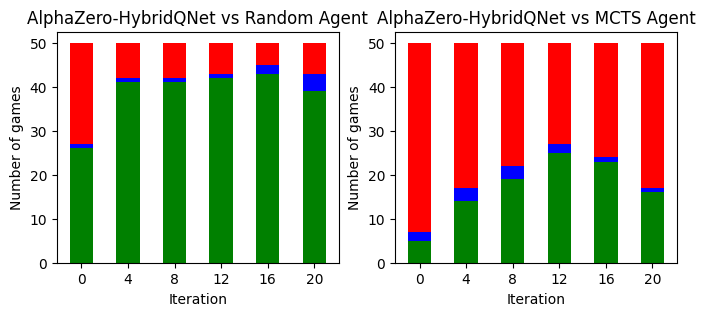

In [6]:
plot_performance_history(hybrid_qnet_coach.performanceHistory, "AlphaZero-HybridQNet")